In [15]:
import keras

In [2]:
import tensorflow as tf

In [3]:
import os
import sys
import cv2
from matplotlib import pyplot as plt
import time
from os import listdir
from os.path import isfile, join, isdir
import numpy as np

In [4]:
main_dir = os.getcwd()

In [5]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

In [6]:
DATASET_PATH = main_dir + "/VIRAT_transformed/"
BATCH_SIZE = 1
EPOCHS = 3
MODEL_PATH = main_dir + "/model_virat.hdf5"

In [16]:
TEST_PATH = os.path.join(DATASET_PATH, 'Test')
TEST_FILE = os.path.join(TEST_PATH, 'test_002.mp4')

In [8]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []

    for video in os.listdir(DATASET_PATH + '/Train'):
        all_frames = []
        vs = cv2.VideoCapture(os.path.join(DATASET_PATH + '/Train', video))
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret == True:
                frame = cv2.resize(frame, (256,256))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame/256
                all_frames.append(frame)
            else:
                vs.release()
                break
        # get the 10-frames sequences from the list
        #for stride in range(1, 3): #applying data augmentation
        #clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
        clips.extend(get_clips_by_stride(stride=1, frames_list=all_frames, sequence_size=10))
    return clips

In [9]:
training_set = get_training_set()

In [10]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=False)
    seq.save(MODEL_PATH)
    return seq

In [11]:
def get_single_test(test_file):
    vs = cv2.VideoCapture(test_file)
    num_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    test = np.zeros(shape=(num_frames, 256, 256, 1))
    count = 0
    while(vs.isOpened()):
        ret, frame = vs.read()     
        if ret == True:
            frame = cv2.resize(frame, (256,256))
            frame = frame[:,:,0] # only one channelm others are the same
            frame = np.array(frame, dtype=np.float32) / 256.0
            test[count, :, :, 0] = frame
        else:
            vs.release()
            break
        count += 1
    return test

In [12]:
#model = get_model(True)

In [20]:
def evaluate():
    model = get_model(False)
    print("got model")
    test = get_single_test(TEST_FILE)
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=BATCH_SIZE)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

got model
got test


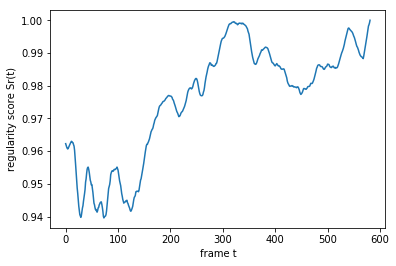

In [21]:
evaluate()

In [25]:
%matplotlib notebook

In [17]:
single_test = get_single_test(TEST_FILE)

In [18]:
single_test.shape

(592, 256, 256, 1)

In [19]:
single_test[:,:,:,0].shape

(592, 256, 256)

In [108]:
single_test[:,:,:,0][0].shape

(256, 256)

In [109]:
single_test[:,:,:,0][0]

array([[0.43359375, 0.43359375, 0.43359375, ..., 0.33203125, 0.3125    ,
        0.234375  ],
       [0.43359375, 0.43359375, 0.43359375, ..., 0.30859375, 0.2578125 ,
        0.1953125 ],
       [0.43359375, 0.43359375, 0.43359375, ..., 0.30859375, 0.203125  ,
        0.1484375 ],
       ...,
       [0.6875    , 0.48828125, 0.125     , ..., 0.1875    , 0.16796875,
        0.15234375],
       [0.71875   , 0.2421875 , 0.16015625, ..., 0.19140625, 0.17578125,
        0.15625   ],
       [0.5546875 , 0.29296875, 0.3671875 , ..., 0.1953125 , 0.1796875 ,
        0.16015625]])

<IPython.core.display.Javascript object>


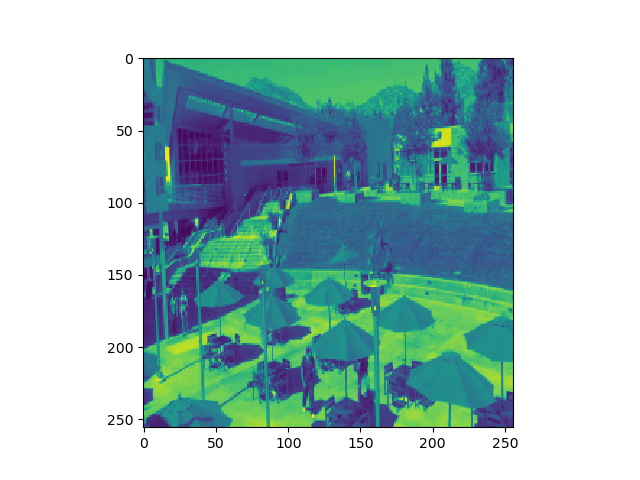

In [110]:
plt.imshow(single_test[:,:,:,0][1])
plt.show()

In [111]:
for frame in single_test[:,:,:,0]:
    cv2.imshow('frame', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [60]:
%matplotlib inline

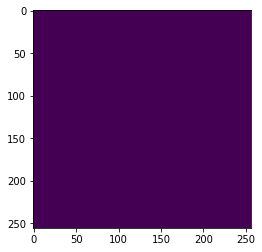

In [62]:
plt.imshow(single_test[:,:,:,0][140])
plt.show()

In [15]:
model = get_model(False)

In [57]:
##All possible sequences
num_sequences = single_test.shape[0] - 10
sequences = np.zeros((num_sequences, 10, 256, 256, 1))
# apply the sliding window technique to get the sequences
for i in range(0, num_sequences):
    clip = np.zeros((10, 256, 256, 1))
    for j in range(0, 10):
        clip[j] = single_test[i + j, :, :, :]
    sequences[i] = clip

In [20]:
sequences.shape

(190, 10, 256, 256, 1)

In [42]:
one_sequence = sequences[10:11,:,:,:]

In [43]:
start = time.time()
reconstructed_sequences = model.predict(one_sequence,batch_size=BATCH_SIZE)
end = time.time() - start
print(end, 'secs')

1.2637946605682373 secs


In [44]:
sequence_reconstruction_cost = np.array([np.linalg.norm(np.subtract(one_sequence[i],reconstructed_sequences[i])) for i in range(0,1)])

In [45]:
sequence_reconstruction_cost

array([ 24.56578652])

In [ ]:
tf.distributions.

In [62]:
##All sequences
start = time.time()
reconstructed_sequences = model.predict(sequences,batch_size=BATCH_SIZE)
end = time.time() - start
print(end, 'secs')

239.0450143814087 secs


In [59]:
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,num_sequences)])


In [60]:
sequences_reconstruction_cost

array([ 28.80097555,  28.77805575,  28.77342082,  28.75582499,
        28.76409286,  28.78651106,  28.82182453,  28.88534091,
        28.92228618,  28.93557294,  28.93882803,  28.98646437,
        29.03756208,  29.08273418,  29.04227021,  29.01948063,
        28.9753882 ,  28.86394317,  28.7217884 ,  28.62456105,
        28.53000184,  28.41768015,  28.31262938,  28.22135302,
        28.10525616,  28.07770504,  28.10839209,  28.17236189,
        28.29967218,  28.41794845,  28.57069083,  28.77712185,
        28.98084471,  29.19783301,  29.44370775,  29.57282531,
        29.65418988,  29.67098113,  29.73539963,  29.87120199,
        30.02544913,  30.10021368,  30.17376171,  30.23901336,
        30.31878983,  30.42918831,  30.49461252,  30.56201203,
        30.57626225,  30.50875897,  30.49291612,  30.51514232,
        30.46899883,  30.46615528,  30.50393299,  30.55143277,
        30.55898542,  30.52517285,  30.47502964,  30.42679868,
        30.41521807,  30.37755046,  30.38531089,  30.38

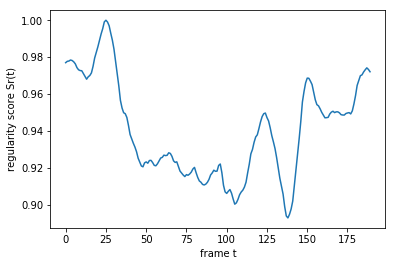

In [61]:
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()